**Instituto de Informática - UFG**

Disciplina: Inteligência Computacional

Prof. Cedric Luiz de Carvalho


Grupo ( J )

---


Analista de dados:
* Arthur Cavalcante de Andrade

---

# Solução para o Problema

O problema remete à previsão do óbito de pacientes internados.

Dessa forma, iremos implementar uma rede neural que seja capaz de prever se um paciente que foi internado em um hospital irá morrer ou não.

#### Carregando as bibliotecas e módulos necessários

In [137]:
import pandas as pd
import numpy as np 
import matplotlib.pyplot as plt
import sklearn
from sklearn.neural_network import MLPClassifier
from sklearn.neural_network import MLPRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, ConfusionMatrixDisplay
from sklearn.metrics import classification_report,confusion_matrix, plot_confusion_matrix
from math import sqrt
from sklearn.metrics import r2_score
from sklearn.datasets import make_classification
from sklearn.svm import SVC

#### Lendo os dados e realizando verificações básicas de dados

In [2]:
df = pd.read_csv('imputed_dataframe.csv') 
print(df.shape)
df.describe().transpose()

(91713, 77)


,count,mean,std,min,25%,50%,75%,max
age,91713.0,62.811510,16.632065,16.000000,53.000000,65.000000,76.000000,89.00000
bmi,91713.0,29.202101,8.136838,14.844926,23.784833,28.000752,32.695312,67.81499
elective_surgery,91713.0,0.183736,0.387271,0.000000,0.000000,0.000000,0.000000,1.00000
ethnicity,91713.0,0.635395,1.369270,0.000000,0.000000,0.000000,0.000000,5.00000
height,91713.0,169.619857,10.841803,137.200000,162.500000,170.100000,177.800000,195.59000
...,...,...,...,...,...,...,...,...
leukemia,91713.0,0.007011,0.083438,0.000000,0.000000,0.000000,0.000000,1.00000
lymphoma,91713.0,0.004100,0.063898,0.000000,0.000000,0.000000,0.000000,1.00000
solid_tumor_with_metastasis,91713.0,0.020477,0.141626,0.000000,0.000000,0.000000,0.000000,1.00000
apache_3j_bodysystem,91713.0,4.168777,3.809760,0.000000,0.000000,5.000000,8.000000,10.00000


Observando o resumo da variável `hospital_death`, observamos que o valor médio é 0.086, o que significa que cerca de 8.6% das observações no conjunto de dados têm diabetes.

Visando uma boa proporção nas amostras, podemos considerar fazer uma rede neural com dados de teste que possuem amostras aleatórias, e outra rede neural com a quantidade de mortes e não mortes com proporções equivalentes.

Em seguida, comparamos os resultados.

#### Criando os conjuntos de dados de treinamento e teste

Inicialmente dividimos a variável de destino e o resto do conjunto de dados, criamos arrays das variáveis independente e dependentes, e separamos dados de treinamento e de teste.

In [4]:
#divide a variável de destino e o resto do conjunto de dados
target_column = ['hospital_death']
predictors = list(set(list(df.columns))-set(target_column))

#cria arrays de variáveis independentes (X) e dependentes (Y)
X = df[predictors].values
y = df[target_column].values

##### Dados aleatórios

Utilizamos 20% do conjunto de dados de forma aleatória para a realização de treinos, enquanto os outros 80% dos dados serão utilizados para teste de desempenho dos modelos.

In [83]:
#divide os dados em conjunto de dados de treinamento e teste
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=40)

print('Forma dos dados de treinamento e teste:')
print(X_train.shape); print(X_test.shape)

Forma dos dados de treinamento e teste:
(73370, 76)
(18343, 76)


##### Dados com proporção balanceada

Para conseguir utilizar proporções, primeiro separamos conjunto de dados em casos de mortes e não mortes.

In [8]:
dfcolumns = list(df.columns.values)
dfcolumns.remove('hospital_death')
dfcolumns

death_cases = df.loc[df['hospital_death'] == 1]
x_death = death_cases[dfcolumns]
y_death = death_cases['hospital_death']

non_death_cases = df.loc[df['hospital_death'] == 0]
x_non_death = non_death_cases[dfcolumns]
y_non_death = non_death_cases['hospital_death']

In [9]:
print("Número de entradas com mortes: ", len(x_death))
print("Número de entradas sem mortes: ", len(x_non_death))

Número de entradas com mortes:  7915
Número de entradas sem mortes:  83798


Distribuímos igualmente a quantidade desses dados em dois parâmetros: `X_balanced` e `y_balanced`

Em seguida, distribuimos em proporções iguais e de forma aleatória 50% destes dados para treinamento e teste, como é mostrado no gráfico abaixo.

Forma dos dados de treinamento e teste:
(7915, 76)
(7915, 76)


<AxesSubplot:title={'center':'Quantidade de dados separados por casos de não morte (0) e morte (1)'}>

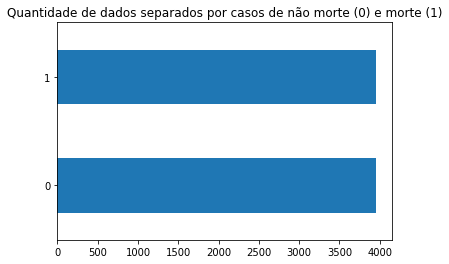

In [11]:
df_balanced = df.groupby('hospital_death').apply(lambda x: x.sample(7915))

y_balanced = df_balanced['hospital_death'].copy()
X_balanced = df_balanced.drop('hospital_death', axis=1).copy()

X_train_balanced, X_test_balanced, y_train_balanced, y_test_balanced =  train_test_split(X_balanced, y_balanced, test_size=0.5, random_state=2)

print('Forma dos dados de treinamento e teste:')
print(X_train_balanced.shape); print(X_test_balanced.shape)

y_train_balanced.value_counts().plot(kind='barh', title='Quantidade de dados separados por casos de não morte (0) e morte (1)')

#### Construindo, Prevendo e Avaliando o Modelo de Rede Neural

Nesta etapa, construiremos o modelo de rede neural usando o objeto estimador da biblioteca scikit-learn, **Multi-Layer Perceptron Classifier**.

##### Dados aleatórios

Inicialmente construímos o modelo de rede neural com os dados aleatórios.

A primeira linha instancia o modelo com o argumento `hidden_layer_sizes` definido como três camadas, que tem o mesmo número de neurônios que a contagem de recursos no conjunto de dados (neste caso 76, como exibido na célula de código anterior). 

A segunda linha ajusta o modelo de dados ao treinamento, enquanto a terceira e quarta linhas usam o modelo treinado para gerar previsões no conjunto de dados de treinamento e teste, respectivamente.

In [157]:
mlp = MLPClassifier(hidden_layer_sizes=(76,76,76), activation='logistic', solver='adam', max_iter=500)
mlp.fit(X_train,y_train)

C:\Users\TECNO\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:1109: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


MLPClassifier(activation='logistic', hidden_layer_sizes=(76, 76, 76),
              max_iter=500)

In [158]:
predict_train = mlp.predict(X_train)
predict_test = mlp.predict(X_test)

Uma vez que as previsões são geradas, podemos avaliar o desempenho do modelo.

O código abaixo imprime a matriz de confusão e os resultados do relatório de confusão nos dados de treinamento.

Resultados para 'predict_train':


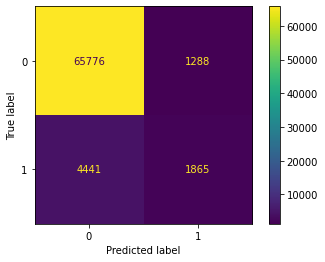

              precision    recall  f1-score   support

           0       0.94      0.98      0.96     67064
           1       0.59      0.30      0.39      6306

    accuracy                           0.92     73370
   macro avg       0.76      0.64      0.68     73370
weighted avg       0.91      0.92      0.91     73370



<Figure size 432x288 with 0 Axes>

In [179]:
print("Resultados para 'predict_train':")
#print(confusion_matrix(y_train,predict_train))
cm = confusion_matrix(y_train, predict_train, labels=mlp.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=mlp.classes_)
disp.plot()
plt.show()
plt.savefig('predict_train.png')

print(classification_report(y_train,predict_train))

O próximo passo é avaliar o desempenho do modelo nos dados de teste.

Resultados para 'predict_test':


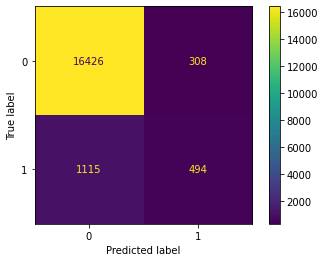

              precision    recall  f1-score   support

           0       0.94      0.98      0.96     16734
           1       0.62      0.31      0.41      1609

    accuracy                           0.92     18343
   macro avg       0.78      0.64      0.68     18343
weighted avg       0.91      0.92      0.91     18343



<Figure size 432x288 with 0 Axes>

In [178]:
print("Resultados para 'predict_test':")
#print(confusion_matrix(y_test,predict_test))
cm = confusion_matrix(y_test, predict_test, labels=mlp.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=mlp.classes_)
disp.plot()
plt.show()
plt.savefig('predict_test.png')

print(classification_report(y_test,predict_test))

##### Dados com proporção balanceada

Em seguida, construímos o modelo de rede neural com os dados proporcionalmente balanceados.

Utilizamos os mesmos parâmetros definidos anteriormente para a construção da rede neural, alterando apenas os dados de treinamento.

In [174]:
mlp_balanced = MLPClassifier(hidden_layer_sizes=(76,76,76), activation='logistic', solver='adam', max_iter=500)
mlp_balanced.fit(X_train_balanced,y_train_balanced)

MLPClassifier(activation='logistic', hidden_layer_sizes=(76, 76, 76),
              max_iter=500)

Após a geração das previsões, novamente podemos avaliar o desempenho do modelo.

Primeiramente utilizando matriz de confusão e os resultados do relatório de confusão nos dados de treinamento.

In [175]:
predict_train_balanced = mlp_balanced.predict(X_train)
predict_test_balanced = mlp_balanced.predict(X_test)

C:\Users\TECNO\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but MLPClassifier was fitted with feature names
  warnings.warn(
C:\Users\TECNO\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but MLPClassifier was fitted with feature names
  warnings.warn(


Resultados para 'predict_train_balanced':


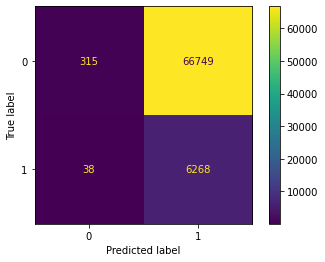

              precision    recall  f1-score   support

           0       0.89      0.00      0.01     67064
           1       0.09      0.99      0.16      6306

    accuracy                           0.09     73370
   macro avg       0.49      0.50      0.08     73370
weighted avg       0.82      0.09      0.02     73370



<Figure size 432x288 with 0 Axes>

In [180]:
print("Resultados para 'predict_train_balanced':")
#print(confusion_matrix(y_train,predict_train))
cm = confusion_matrix(y_train, predict_train_balanced, labels=mlp_balanced.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=mlp_balanced.classes_)
disp.plot()
plt.show()
plt.savefig('predict_train_balanced.png')

print(classification_report(y_train,predict_train_balanced))

E por fim, avaliando o desempenho do modelo nos dados de teste.

Resultados para 'predict_test_balanced':


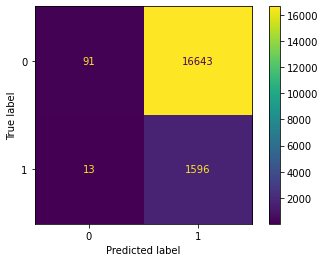

              precision    recall  f1-score   support

           0       0.88      0.01      0.01     16734
           1       0.09      0.99      0.16      1609

    accuracy                           0.09     18343
   macro avg       0.48      0.50      0.09     18343
weighted avg       0.81      0.09      0.02     18343



<Figure size 432x288 with 0 Axes>

In [181]:
print("Resultados para 'predict_test_balanced':")
#print(confusion_matrix(y_test,predict_test))
cm = confusion_matrix(y_test, predict_test_balanced, labels=mlp_balanced.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=mlp_balanced.classes_)
disp.plot()
plt.show()
plt.savefig('predict_test_balanced.png')

print(classification_report(y_test,predict_test_balanced))

#### Avaliação do desempenho dos modelos

Ao comparar os resultados dos modelos gerados, obtivemos as seguintes conclusões:

* Quanto maior a quantidade de dados de treino, mais alta a precisão das previsões geradas.

* Utilizando os dados aleatórios, observamos que a rede neural tende a prever com maior frequência que os casos encontrados não resultarão em mortes, isso porque é levado em conta a baixa frequência de mortes resultantes nos dados de treinamento.

* Utilizando os dados balanceados, a rede neural é treinada com uma possibilidade muito mais recorrente para casos de morte (o que não é uma estimativa real para todo o resto dos dados), que acaba resultando em previsões frequentes para casos de morte.

Para que a precisão dos modelos gerados aumente, é importante utilizar dados com proporções ded resultaddos próximas do contexto geral, utilizando a maior quantidade de dados de treinamento possível.